In [1]:
! pip install torch-geometric 
! pip install node2vec networkx
! pip install matplotlib imageio scikit-learn tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 1.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 26.8 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 10.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 40.2 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: networkx
    Found existing installation: networkx 3.2.1
    Uninstalling networkx-3.2.1:
      Successfully uninstalled networkx-3.2.1


In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from random import randint

import pandas as pd
import math
import os
import psutil
import time
import tempfile
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import imageio.v2 as imageio
from tqdm import tqdm


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from scipy.stats import multivariate_normal, pearsonr
from scipy.spatial.distance import jensenshannon
from scipy.sparse.linalg import eigsh
from scipy.sparse import csgraph


import torch.nn.utils as nn_utils
import torch.nn.functional as F
from torch.nn import Tanh, Linear, Sequential, ReLU
from torch.nn.modules.module import Module

import torch_geometric
from torch_geometric.nn import GCNConv, GATConv, SAGEConv, NNConv

In [3]:
random_seed = 42

def set_seed(random_seed):
    random.seed(random_seed)
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)

set_seed(random_seed)

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
else:
    device = torch.device("cpu")
print(f'using {device}')

using cuda


In [70]:
# Antivectorize given vector into adjacency matrix
def antiVectorize(vec, m):
    M = np.zeros((m,m))
    M[np.tril_indices(m,k=-1)] = vec
    M= M.transpose()
    M[np.tril_indices(m,k=-1)] = vec
    return M

# Vectorize graph adjacency matrix into a vector
def vectorize(M):
    return M[np.tril_indices(M.shape[0], k=-1)]

# Data Preparation

In [4]:
# dataset_path = '/Users/gitaayusalsabila/Documents/0thesis/code/sandbox/dataset/'
dataset_path = '/notebooks/dataset/'

In [5]:
def multivariate_simulate(datapath, n_samples=200,n_time=2,n_views=4):
    # Note that changing the node count is not provided right now, since we use correlation matrix
    # and the mean values of connectivities from real data and it is for 35 nodes.
    
    # Import all required statistical information.
    allstats = np.load(datapath + "stats/REAL_TIME_DIFF.npy") # Connectivity mean values of LH. You can also try with RH.
    allcorrs = np.load(datapath + "stats/REAL_TIME_DIFF.npy") # Correlation matrix in LH. You can also try with RH.
    all_diffs = np.load(datapath + "stats/REAL_TIME_DIFF.npy") # This is an overall representation of time differences in both (LH and RH) datasets.
    
    times = []
    for t in range(n_time):
        views = []
        for v in range(n_views):
            # Note that we randomly assign a new random state to ensure it will generate a different dataset at each run.
            # Generate data with the correlations and mean values at the current timepoint.
            if t < 2:
                connectomic_means = allstats[t,v]
                data = multivariate_normal.rvs(connectomic_means,allcorrs[t,v],n_samples,random_state=randint(1,9999))
            # If the requested timepoints are more than we have in real data, use the correlation information from the last timepoint.
            else:
                connectomic_means = allstats[-1,v]
                data = multivariate_normal.rvs(connectomic_means,allcorrs[-1,v],n_samples,random_state=randint(1,9999))

            adj = []
            for idx, sample in enumerate(data):
                # Create adjacency matrix.
                matrix = antiVectorize(sample,35)
                # Perturb the real time difference with nonlinear tanh function.
                noise = np.tanh( t / n_time )
                # Further timepoints will have more significant difference from the baseline (t=6 >> t=1).
                matrix = matrix + all_diffs[:,:,v] * ( noise + 1 )
                adj.append(matrix)
            views.append(np.array(adj))

        times.append(np.array(views))
    
    alldata=np.array(times)
    alldata = np.transpose(alldata,(2,0,3,4,1))
    return alldata 

def prepare_data(datapath, new_data=False, n_samples=200, n_times=6):
    # Note that data with 200 samples and 6 timepoints is very large (5.8M data points),
    # check your GPU memory to make sure there is enough space to allocate. If not, try:
    # - to reduce dataset size by changing n_samples or n_times.
    # - on CPU (this will allocate memory on RAM) --> This might work for example if you have 1GB GPU memory but 16GB RAM.
    # - on another computer with a better NVIDIA graphics card. --> 2GB GPU memory will not be enough for 5.8M data.
    try:
        if new_data:
            samples = multivariate_simulate(datapath, n_samples, n_times)
            np.save(datapath + 'simulated_adj.npy',samples)
        else:
            samples = np.load(datapath + 'simulated_adj.npy')
    except:
        samples = multivariate_simulate(datapath, n_samples, n_times)
        np.save(datapath + 'simulated_adj.npy',samples)
    return samples

def data_cleansing(dataset):
    # Replace negative values with 0
    dataset[dataset < 0] = 0
    
    # Replace NaN values with 0
    dataset = np.nan_to_num(dataset, nan=0)
    
    return dataset

def check_and_drop_invalid_graphs(graph_dataset):
    """
    Check that all graphs in the dataset have more than 0 edges and drop graphs with 0 edges in any timepoint or dimension.
    
    Parameters:
    graph_dataset (np.ndarray): The input graph dataset with shape [g, t, n, n, d] or [g, t, n, n]
    
    Returns:
    np.ndarray: The cleaned dataset with invalid graphs removed
    """
    
    # Check the shape of the dataset to determine if it has multiple dimensions
    if len(graph_dataset.shape) == 5:
        num_graphs, num_timepoints, num_nodes, _, num_dimensions = graph_dataset.shape
    else:
        num_graphs, num_timepoints, num_nodes, _ = graph_dataset.shape
        num_dimensions = 1
    
    valid_graphs = []

    for i in range(num_graphs):
        is_valid = True
        for t in range(num_timepoints):
            for d in range(num_dimensions):
                if num_dimensions > 1:
                    adj_matrix = graph_dataset[i, t, :, :, d]
                else:
                    adj_matrix = graph_dataset[i, t, :, :]
                
                num_edges = np.sum(adj_matrix > 0)
                if num_edges == 0:
                    is_valid = False
                    break
            if not is_valid:
                break
        
        if is_valid:
            valid_graphs.append(i)
    
    if num_dimensions > 1:
        cleaned_dataset = graph_dataset[valid_graphs, :, :, :, :]
    else:
        cleaned_dataset = graph_dataset[valid_graphs, :, :, :]
    
    return cleaned_dataset

def normalize_adj_matrix(adj):
    # Calculate the degree matrix
    degrees = np.sum(adj, axis=1) # Sum of weights for each node
    degrees[degrees == 0] = 1
    D_hat_inv_sqrt = np.diag(1.0 / np.sqrt(degrees))
    
    # Perform the normalization
    normalized_adj = D_hat_inv_sqrt.dot(adj).dot(D_hat_inv_sqrt)
    
    return normalized_adj

def normalize_graph_dataset(dataset, single=False):
    normalized_dataset = np.zeros_like(dataset)

    if single==False:
        num_graphs, num_timepoints, _, _, num_domain = dataset.shape
        
        for i in range(num_graphs):
            for t in range(num_timepoints):
                for d in range(num_domain):
                    adjacency_matrix = dataset[i, t, :, :, d]
                    normalized_adjacency_matrix = normalize_adj_matrix(adjacency_matrix)
                    normalized_dataset[i, t, :, :, d] = normalized_adjacency_matrix
    else:
        num_graphs, num_timepoints, _, _ = dataset.shape
        
        for i in range(num_graphs):
            for t in range(num_timepoints):
                adjacency_matrix = dataset[i, t, :, :]
                normalized_adjacency_matrix = normalize_adj_matrix(adjacency_matrix)
                normalized_dataset[i, t, :, :] = normalized_adjacency_matrix
    
    return normalized_dataset

In [6]:
# Load Graph Data
simulated_data = prepare_data(dataset_path, new_data=False, n_samples=100, n_times=3)
slim160 = np.load(dataset_path + 'slim160_adj.npy')
slim268 = np.load(dataset_path + 'slim268_adj.npy')


# Clean Computed Graph Adj Matrix
simulated_cleaned = data_cleansing(simulated_data)
simulated_cleaned = check_and_drop_invalid_graphs(simulated_data)
simulated_normalized = normalize_graph_dataset(simulated_cleaned)
print('simulated data shape:',simulated_normalized.shape)

slim160_cleaned = data_cleansing(slim160)
slim160_cleaned = check_and_drop_invalid_graphs(slim160_cleaned)
print('slim160 shape:',slim160_cleaned.shape)

slim268_cleaned = data_cleansing(slim268)
slim268_cleaned = check_and_drop_invalid_graphs(slim268_cleaned)
print('slim268 shape:',slim268_cleaned.shape)


# Load Precomputed Graph (Node) Features
## Laplacian Encoding
simulated_laplacian_features = np.load(dataset_path + 'simulated_laplacian_features.npy') 
slim160_laplacian_features = np.load(dataset_path + 'slim160_laplacian_features.npy') 
slim268_laplacian_features = np.load(dataset_path + 'slim268_laplacian_features.npy') 

## Degree Encoding
simulated_degree_features = np.load(dataset_path + 'simulated_degree_features.npy') 
slim160_degree_features = np.load(dataset_path + 'slim160_degree_features.npy') 
slim268_degree_features = np.load(dataset_path + 'slim268_degree_features.npy') 

simulated data shape: (100, 3, 35, 35, 4)
slim160 shape: (109, 3, 160, 160)
slim268 shape: (109, 3, 268, 268)


In [7]:
def split_graph_dataset(adj_matrix, node_feature, test_size=0.2, random_state=42):
    # Get the number of graphs
    num_graphs = adj_matrix.shape[0]
    
    # Generate indices for splitting
    indices = np.arange(num_graphs)
    
    # Split the indices
    train_indices, test_indices = train_test_split(indices, test_size=test_size, random_state=random_state)
    
    # Split the adjacency matrices and node features based on the indices
    adj_train, adj_test = adj_matrix[train_indices], adj_matrix[test_indices]
    features_train, features_test = node_feature[train_indices], node_feature[test_indices]
    
    return adj_train, adj_test, features_train, features_test

# Function to split the dataset into training and test sets for each domain
def split_dataset_by_domain(adj_matrix, node_features, test_size=0.2, random_state=42):
    num_subjects, num_timepoints, num_nodes, num_features, num_domains = node_features.shape
    
    # Initialize lists to store train and test sets for each domain
    adj_train_sets, adj_test_sets = [], []
    features_train_sets, features_test_sets = [], []
    
    for domain in range(num_domains):
        # Extract data for the current domain
        adj_domain = adj_matrix[..., domain]
        features_domain = node_features[..., domain]
        
        # Generate subject labels
        subject_labels = np.arange(num_subjects)
        
        # Split the dataset for the current domain
        train_idx, test_idx = train_test_split(subject_labels, test_size=test_size, random_state=random_state)
        
        # Create train and test sets for the current domain
        adj_train, adj_test = adj_domain[train_idx], adj_domain[test_idx]
        features_train, features_test = features_domain[train_idx], features_domain[test_idx]
        
        # Append the train and test sets to the lists
        adj_train_sets.append(adj_train)
        adj_test_sets.append(adj_test)
        features_train_sets.append(features_train)
        features_test_sets.append(features_test)
    
    return adj_train_sets, adj_test_sets, features_train_sets, features_test_sets

In [9]:
adj_matrix = simulated_normalized
node_features = simulated_laplacian_features
num_domains = 4


# Split the dataset by domain
adj_train_sets, adj_test_sets, features_train_sets, features_test_sets = split_dataset_by_domain(adj_matrix, node_features)

adj_train_domains = []
features_train_domains = []
adj_test_domains = []
features_test_domains = []

for domain in range(num_domains):
    print(f'Domain {domain+1} - Adjacency Train set shape: {adj_train_sets[domain].shape}, Test set shape: {adj_test_sets[domain].shape}')
    print(f'Domain {domain+1} - Node Features Train set shape: {features_train_sets[domain].shape}, Test set shape: {features_test_sets[domain].shape}')
    
    adj_train_domains.append(torch.tensor(adj_train_sets[domain], dtype=torch.float32))
    features_train_domains.append(torch.tensor(features_train_sets[domain], dtype=torch.float32))
    adj_test_domains.append(torch.tensor(adj_test_sets[domain], dtype=torch.float32))
    features_test_domains.append(torch.tensor(features_test_sets[domain], dtype=torch.float32))

## Training with simulated data
adj_train_domain_1 = adj_train_domains[0]
adj_train_domain_2 = adj_train_domains[1]
adj_train_domain_3 = adj_train_domains[2]
adj_train_domain_4 = adj_train_domains[3] 

x_train_domain_1 = features_train_domains[0]
x_train_domain_2 = features_train_domains[1]
x_train_domain_3 = features_train_domains[2]
x_train_domain_4 = features_train_domains[3]


## Testing with simulated data
adj_test_domain_1 = adj_test_domains[0]
adj_test_domain_2 = adj_test_domains[1]
adj_test_domain_3 = adj_test_domains[2]
adj_test_domain_4 = adj_test_domains[3] 

x_test_domain_1 = features_test_domains[0]
x_test_domain_2 = features_test_domains[1]
x_test_domain_3 = features_test_domains[2]
x_test_domain_4 = features_test_domains[3]

Domain 1 - Adjacency Train set shape: (80, 3, 35, 35), Test set shape: (20, 3, 35, 35)
Domain 1 - Node Features Train set shape: (80, 3, 35, 8), Test set shape: (20, 3, 35, 8)
Domain 2 - Adjacency Train set shape: (80, 3, 35, 35), Test set shape: (20, 3, 35, 35)
Domain 2 - Node Features Train set shape: (80, 3, 35, 8), Test set shape: (20, 3, 35, 8)
Domain 3 - Adjacency Train set shape: (80, 3, 35, 35), Test set shape: (20, 3, 35, 35)
Domain 3 - Node Features Train set shape: (80, 3, 35, 8), Test set shape: (20, 3, 35, 8)
Domain 4 - Adjacency Train set shape: (80, 3, 35, 35), Test set shape: (20, 3, 35, 35)
Domain 4 - Node Features Train set shape: (80, 3, 35, 8), Test set shape: (20, 3, 35, 8)


In [10]:
slim160_adj_matrix = slim160_cleaned
slim160_node_features = slim160_laplacian_features

adj_train_slim160, adj_test_slim160, features_train_slim160, features_test_slim160 = split_graph_dataset(slim160_adj_matrix, slim160_node_features)

# Print shapes to verify
print(f'adj_train_slim160 shape: {adj_train_slim160.shape}')
print(f'adj_test_slim160 shape: {adj_test_slim160.shape}')
print(f'features_train_160 shape: {features_train_slim160.shape}')
print(f'features_test_slim160 shape: {features_test_slim160.shape}')

slim268_adj_matrix = slim268_cleaned
slim268_node_features = slim268_laplacian_features

adj_train_slim268, adj_test_slim268, features_train_slim268, features_test_slim268 = split_graph_dataset(slim268_adj_matrix, slim268_node_features)

# Print shapes to verify
print(f'\nadj_train_slim268 shape: {adj_train_slim268.shape}')
print(f'adj_test_slim268 shape: {adj_test_slim268.shape}')
print(f'features_train_268 shape: {features_train_slim268.shape}')
print(f'features_test_slim268 shape: {features_test_slim268.shape}')

adj_train_slim160 = torch.tensor(adj_train_slim160, dtype=torch.float32) 
x_train_slim160 = torch.tensor(features_train_slim160, dtype=torch.float32)  
adj_test_slim160 = torch.tensor(adj_test_slim160, dtype=torch.float32)  
x_test_slim160 = torch.tensor(features_test_slim160, dtype=torch.float32)  

adj_train_slim268 = torch.tensor(adj_train_slim268, dtype=torch.float32)
x_train_slim268 = torch.tensor(features_train_slim268, dtype=torch.float32)
adj_test_slim268 = torch.tensor(adj_test_slim268, dtype=torch.float32)
x_test_slim268 = torch.tensor(features_test_slim268, dtype=torch.float32)

adj_train_slim160 shape: (87, 3, 160, 160)
adj_test_slim160 shape: (22, 3, 160, 160)
features_train_160 shape: (87, 3, 160, 32)
features_test_slim160 shape: (22, 3, 160, 32)

adj_train_slim268 shape: (87, 3, 268, 268)
adj_test_slim268 shape: (22, 3, 268, 268)
features_train_268 shape: (87, 3, 268, 32)
features_test_slim268 shape: (22, 3, 268, 32)


# Benchmark Model

## RGBM

In [11]:
def eucledian_distance(x):
  repeated_out = x.repeat(35,1,1)
  repeated_t = torch.transpose(repeated_out, 0, 1)
  diff = torch.abs(repeated_out - repeated_t)
  return torch.sum(diff, 2)

def frobenious_distance(test_sample,predicted):
  diff = torch.abs(test_sample - predicted)
  dif = diff*diff
  sum_of_all = diff.sum()
  d = torch.sqrt(sum_of_all)
  return d

def create_edge_index_attribute(adj_matrix):
    rows, cols = adj_matrix.shape[0], adj_matrix.shape[1]
    edge_index = torch.zeros((2, rows * cols), dtype=torch.long, device='cuda')
    edge_attr = torch.zeros((rows * cols, 1), dtype=torch.float, device='cuda')
    counter = 0

    for src, attrs in enumerate(adj_matrix):
        for dest, attr in enumerate(attrs):
            edge_index[0][counter], edge_index[1][counter] = src, dest
            edge_attr[counter] = attr
            counter += 1

    return edge_index, edge_attr, rows, cols

In [29]:
class RNNCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, hidden_state):
        super(RNNCell, self).__init__()
        self.weight = nn.Linear(input_dim, hidden_dim, bias=True)
        self.weight_h = nn.Linear(hidden_dim, hidden_dim, bias=True)
        self.out = nn.Linear(hidden_dim, hidden_dim, bias=True)
        self.tanh = Tanh()
        self.hidden_state = hidden_state
    
    def forward(self,x):
        h = self.hidden_state
        y = self.tanh(self.weight(x.to(device)) + self.weight_h(h))
        self.hidden_state = y.detach()
        return y


class RBGM(nn.Module):
    def __init__(self, conv_size, hidden_state_size):
        super(RBGM, self).__init__()
        shape = torch.Size((hidden_state_size, hidden_state_size))
        hidden_state = torch.rand(shape, device=device)
        self.rnn = nn.Sequential(RNNCell(1,hidden_state_size, hidden_state), ReLU())
        self.gnn_conv = NNConv(conv_size, conv_size, self.rnn, aggr='mean', root_weight=True, bias = True)
        
    def forward(self, data):
        edge_index, edge_attr, _, _ = create_edge_index_attribute(data)
        x1 = F.relu(self.gnn_conv(data, edge_index, edge_attr))
        x1 = eucledian_distance(x1)
        return x1

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [30]:
def train_rbgm(model_1, model_2, train_adj, num_epochs=100, lr=0.001, save_path='models/RBGM/rgbm_model', lambda_1 = 10):
    # Loss Function
    mael = torch.nn.L1Loss().to(device)
    tp = torch.nn.MSELoss().to(device)

    optimizer_1 = torch.optim.Adam(model_1.parameters(), lr = lr)
    optimizer_2 = torch.optim.Adam(model_2.parameters(), lr = lr)

    training_loss = []
    epoch_time = []
    cpu_usage = []
    memory_usage = []
    
    for epoch in range(num_epochs):
        total_loss_1, total_loss_2 = 0.0, 0.0 
        tp_loss_1, tp_loss_2, gen_loss_1, gen_loss_2 = 0.0, 0.0, 0.0, 0.0

        epoch_loss = 0
        epoch_gen_loss = 0
        epoch_top_loss = 0
        
        set_seed(42)
        model_1.train()
        model_2.train()

        epoch_start_time = time.time()
        cpu_usage = []
        memory_usage = []
        
        for i in tqdm(range(train_adj.size(0)), desc=f'Epoch {epoch+1}/{num_epochs}'):
        # for i, data in enumerate(h_data_train_loader):
            
            data = train_adj.to(device)
            
            data_t0 = data[i, 0]
            data_t1 = data[i, 1]
            data_t2 = data[i, 2]
            
            #Time Point 1
            optimizer_1.zero_grad()
            out_1 = model_1(data_t0)
            
            tpl_1 = tp(out_1.sum(dim=-1), data_t1.sum(dim=-1))
            tp_loss_1 += tpl_1.item()
            genl_1 = mael(out_1, data_t1)
            gen_loss_1 += genl_1.item()
            
            loss_1 = genl_1 + (lambda_1 * tpl_1)
            total_loss_1 += loss_1.item()
            loss_1.backward()
            optimizer_1.step()
            
            #Time Point 2
            optimizer_2.zero_grad()
            out_2 = model_2(data_t1)
            
            tpl_2 = tp(out_2.sum(dim=-1), data_t2.sum(dim=-1))
            tp_loss_2 += tpl_2.item()
            
            genl_2 = mael(out_2, data_t2)
            gen_loss_2 += genl_2.item()
            
            loss_2 = genl_2 + lambda_1 * tpl_2
            total_loss_2 += loss_2.item()
            loss_2.backward()
            optimizer_2.step()

            #All Training Loss
            epoch_loss      = total_loss_1 + total_loss_2
            epoch_gen_loss  = gen_loss_1 + gen_loss_2
            epoch_tp_loss   = tp_loss_1 + tp_loss_2    
        
        epoch_end_time = time.time()
        epoch_time.append(epoch_end_time - epoch_start_time)
        cpu_usage.append(psutil.cpu_percent(interval=None))
        memory_usage.append(psutil.virtual_memory().percent)

        epoch_loss /= train_adj.size(0)
        # epoch_gen_loss /= train_adj.size(0)
        # epoch_top_loss /= train_adj.size(0)
        training_loss.append(epoch_loss)
        
        print(f'Epoch {epoch + 1}, Loss: {epoch_loss}, Generative Loss: {epoch_gen_loss}, Topological Loss: {epoch_tp_loss}')
        print(f'Time: {epoch_time[-1]:.2f}s, CPU: {cpu_usage[-1]:.2f}%, Memory: {memory_usage[-1]:.2f}%\n')
        

    # Plot the training loss
    plt.plot(training_loss)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()

    # Save the trained model
    save_path_1 = save_path + '_model_1.pth'
    save_path_2 = save_path + '_model_2.pth'
    torch.save(model_1.state_dict(), save_path_1)
    torch.save(model_2.state_dict(), save_path_2)
    print(f'Model saved to {save_path}')

    print(f'Average Time per Epoch: {np.mean(epoch_time):.2f}s')
    print(f'Average CPU Usage: {np.mean(cpu_usage):.2f}%')
    print(f'Average Memory Usage: {np.mean(memory_usage):.2f}%')

    print(f'\nTotal Training Time: {np.sum(epoch_time):.2f}s')
    print(f'Max CPU Usage: {np.max(cpu_usage):.2f}%')
    print(f'Max Memory Usage: {np.max(memory_usage):.2f}%')   

### Simulated Dataset

#### Domain 1

In [ ]:
conv_size = adj_train_domain_1.shape[2]
hidden_size = conv_size*conv_size
rbgm_simulated_dom1_model_1 = RBGM(conv_size, hidden_size).to(device)
rbgm_simulated_dom1_model_2 = RBGM(conv_size, hidden_size).to(device)

print(rbgm_simulated_dom1_model_1)
print(f"Total number of trainable parameters: {(rbgm_simulated_dom1_model_1.count_parameters())*2}\n")

# Train model 
train_rbgm(rbgm_simulated_dom1_model_1, rbgm_simulated_dom1_model_2, 
            adj_train_domain_1, num_epochs=100, lr=0.0001, 
            save_path="models/RBGM/rbgm_simulated_dom1")

### SLIM Dataset

In [35]:
conv_size = adj_train_slim160.shape[2]
hidden_size = conv_size*conv_size
rbgm_simulated_slim160_model_1 = RBGM(conv_size, hidden_size).to(device)
rbgm_simulated_slim160_model_2 = RBGM(conv_size, hidden_size).to(device)

print(rbgm_simulated_slim160_model_1)
print(f"Total number of trainable parameters: {(rbgm_simulated_slim160_model_1.count_parameters())*2}\n")

# Train model 
train_rbgm(rbgm_simulated_slim160_model_1, rbgm_simulated_slim160_model_2, 
            adj_train_slim160, num_epochs=200, lr=0.0001, 
            save_path="models/RBGM/rbgm_slim160")

RBGM(
  (rnn): Sequential(
    (0): RNNCell(
      (weight): Linear(in_features=1, out_features=25600, bias=True)
      (weight_h): Linear(in_features=25600, out_features=25600, bias=True)
      (out): Linear(in_features=25600, out_features=25600, bias=True)
      (tanh): Tanh()
    )
    (1): ReLU()
  )
  (gnn_conv): NNConv(160, 160, aggr=mean, nn=Sequential(
    (0): RNNCell(
      (weight): Linear(in_features=1, out_features=25600, bias=True)
      (weight_h): Linear(in_features=25600, out_features=25600, bias=True)
      (out): Linear(in_features=25600, out_features=25600, bias=True)
      (tanh): Tanh()
    )
    (1): ReLU()
  ))
)
Total number of trainable parameters: 2621696320



Epoch 1/200:   0%|          | 0/87 [00:01<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.44 GiB. GPU 0 has a total capacty of 15.89 GiB of which 326.69 MiB is free. Process 2917816 has 15.57 GiB memory in use. Of the allocated memory 14.87 GiB is allocated by PyTorch, and 100.89 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

## EvoNet

# Evaluation & Inference

In [44]:
# Define plot_heatmaps function if not already defined
def plot_heatmaps_each_timepoint(input_adj, ground_truth_adj, reconstructed_adj, residual_adj, time_point):
    fig, ax = plt.subplots(1, 4, figsize=(20, 5))

    ax[0].imshow(input_adj.cpu().detach().numpy(), cmap='YlGnBu', interpolation='nearest')
    ax[0].set_title(f'Input Graph at Time {time_point}')

    ax[1].imshow(ground_truth_adj.cpu().detach().numpy(), cmap='YlGnBu', interpolation='nearest')
    ax[1].set_title(f'Ground Truth Graph at Time {time_point+1}')

    ax[2].imshow(reconstructed_adj.cpu().detach().numpy(), cmap='YlGnBu', interpolation='nearest')
    ax[2].set_title(f'Generated Graph at Time {time_point+1}')

    ax[3].imshow(residual_adj.cpu().detach().numpy(), cmap='YlGnBu', interpolation='nearest')
    ax[3].set_title(f'Residual Graph at Time {time_point+1}')

    plt.show()

def plot_heatmaps_across_timepoints(input_adj, ground_truth_adj, reconstructed_adj, time_point):
    fig, ax = plt.subplots(1, 3, figsize=(18, 5))

    cax0 = ax[0].imshow(input_adj.cpu().detach().numpy(), cmap='YlGnBu', interpolation='nearest')
    ax[0].set_title(f'Graph at Time {time_point}')
    fig.colorbar(cax0, ax=ax[0])

    cax1 = ax[1].imshow(ground_truth_adj.cpu().detach().numpy(), cmap='YlGnBu', interpolation='nearest')
    ax[1].set_title(f'Graph at Time {time_point+1}')
    fig.colorbar(cax1, ax=ax[1])

    cax2 = ax[2].imshow(reconstructed_adj.cpu().detach().numpy(), cmap='YlGnBu', interpolation='nearest')
    ax[2].set_title(f'Residual Graph between Time {time_point} and {time_point+1}')
    fig.colorbar(cax2, ax=ax[2])

    plt.show()

In [42]:
# Select a sample
sample_idx = 10

## RBGM

In [39]:
def inference_model(model_1, model_2, model_path, adj, sample_idx=0):
    # Load the saved model
    model_path_1 = model_path + '_model_1.pth'
    model_path_2 = model_path + '_model_2.pth'
    model_1.load_state_dict(torch.load(model_path_1))
    model_2.load_state_dict(torch.load(model_path_2))
    model_1.eval()
    model_2.eval()


    # Perform inference
    with torch.no_grad():
        # Generate graph at time point 1 given graph at time point 0
        recon_adj_1  = model_1(adj[sample_idx, 0])
        residual_adj_1 = recon_adj_1 - adj[sample_idx, 1]
        plot_heatmaps_each_timepoint(adj[sample_idx, 0], adj[sample_idx, 1], recon_adj_1, residual_adj_1, 0)

        # Generate graph at time point 2 given graph at time point 1
        recon_adj_2 = model_2(adj[sample_idx, 1])
        residual_adj_2 = recon_adj_2 - adj[sample_idx, 2]
        plot_heatmaps_each_timepoint(adj[sample_idx, 1], adj[sample_idx, 2], recon_adj_2, residual_adj_2, 1)

        residual_between_gt = adj[sample_idx, 2] - adj[sample_idx, 1]
        mse_residual_between_gt = np.mean(np.square(residual_between_gt.cpu().detach().numpy()))
        print("Mean Squared Error between ground truth graphs: ", mse_residual_between_gt)
        plot_heatmaps_across_timepoints(adj[sample_idx, 1], adj[sample_idx, 2], residual_between_gt, 1)
        
        residual_between_outputs = recon_adj_2 - recon_adj_1
        mse_residual_between_outputs = np.mean(np.square(residual_between_outputs.cpu().detach().numpy()))
        print("Mean Squared Error between generated graphs: ", mse_residual_between_outputs)
        plot_heatmaps_across_timepoints(recon_adj_1, recon_adj_2, residual_between_outputs, 1)

In [79]:
def evaluate_model(model_1, model_2, adj_test):
    num_test_samples = adj_test.shape[0]
    num_roi = adj_test.shape[2]

    # Initialize lists to store MAEs for each centrality measure
    mae_bc = []
    mae_ec = []
    mae_pc = []

    pred_1d_list = []
    gt_1d_list = []

    pred_matrices_all = []
    gt_matrices_all = []

    with torch.no_grad():
        for i in range(num_test_samples):
            set_seed(42)
            
            # Predict adjacency matrix at time point t-1
            recon_adj_t_1= model_1(adj_test[i, 0])
            pred_matrices_all.append(recon_adj_t_1.cpu().numpy())
            adj_t_gt_1 = adj_test[i, 0]  
            gt_matrices_all.append(adj_t_gt_1.cpu().numpy())
            
            pred_1d_list.append(vectorize(recon_adj_t_1.cpu().numpy()))
            gt_1d_list.append(vectorize(adj_t_gt_1.cpu().numpy()))


            # Predict adjacency matrix at time point t-1
            recon_adj_t_2= model_2(adj_test[i, 1])
            pred_matrices_all.append(recon_adj_t_2.cpu().numpy())
            adj_t_gt_2 = adj_test[i, 2]  
            gt_matrices_all.append(adj_t_gt_2.cpu().numpy())

            pred_1d_list.append(vectorize(recon_adj_t_2.cpu().numpy()))
            gt_1d_list.append(vectorize(adj_t_gt_2.cpu().numpy()))
    
    
    for i in range(len(pred_matrices_all)):
        # Convert adjacency matrices to NetworkX graphs
        pred_graph = nx.from_numpy_array(pred_matrices_all[i])
        gt_graph = nx.from_numpy_array(gt_matrices_all[i])

        # Compute centrality measures
        pred_bc = nx.betweenness_centrality(pred_graph, weight="weight")
        pred_ec = nx.eigenvector_centrality(pred_graph, weight="weight")
        pred_pc = nx.pagerank(pred_graph, weight="weight")

        gt_bc = nx.betweenness_centrality(gt_graph, weight="weight")
        gt_ec = nx.eigenvector_centrality(gt_graph, weight="weight")
        gt_pc = nx.pagerank(gt_graph, weight="weight")

        # Convert centrality dictionaries to lists
        pred_bc_values = list(pred_bc.values())
        pred_ec_values = list(pred_ec.values())
        pred_pc_values = list(pred_pc.values())

        gt_bc_values = list(gt_bc.values())
        gt_ec_values = list(gt_ec.values())
        gt_pc_values = list(gt_pc.values())

        # Compute MAEs
        mae_bc.append(mean_absolute_error(pred_bc_values, gt_bc_values))
        mae_ec.append(mean_absolute_error(pred_ec_values, gt_ec_values))
        mae_pc.append(mean_absolute_error(pred_pc_values, gt_pc_values))

        

    # Compute average MAEs
    avg_mae_bc = sum(mae_bc) / len(mae_bc)
    avg_mae_ec = sum(mae_ec) / len(mae_ec)
    avg_mae_pc = sum(mae_pc) / len(mae_pc)

    # Concatenate flattened matrices
    pred_1d = np.concatenate(pred_1d_list)
    gt_1d = np.concatenate(gt_1d_list)

    # Compute metrics
    mae = mean_absolute_error(pred_1d, gt_1d)
    pcc = pearsonr(pred_1d, gt_1d)[0]
    js_dis = jensenshannon(pred_1d, gt_1d)

    print("MAE: ", mae)
    print("PCC: ", pcc)
    print("Jensen-Shannon Distance: ", js_dis)
    print("Average MAE betweenness centrality:", avg_mae_bc)
    print("Average MAE eigenvector centrality:", avg_mae_ec)
    print("Average MAE PageRank centrality:", avg_mae_pc)

    return mae, pcc, js_dis, avg_mae_bc, avg_mae_ec, avg_mae_pc

MAE:  0.33227986
PCC:  0.7528312623968462
Jensen-Shannon Distance:  0.1757966140814301
Average MAE betweenness centrality: 0.06784313725490194
Average MAE eigenvector centrality: 0.01427802954688114
Average MAE PageRank centrality: 0.002578641398080183


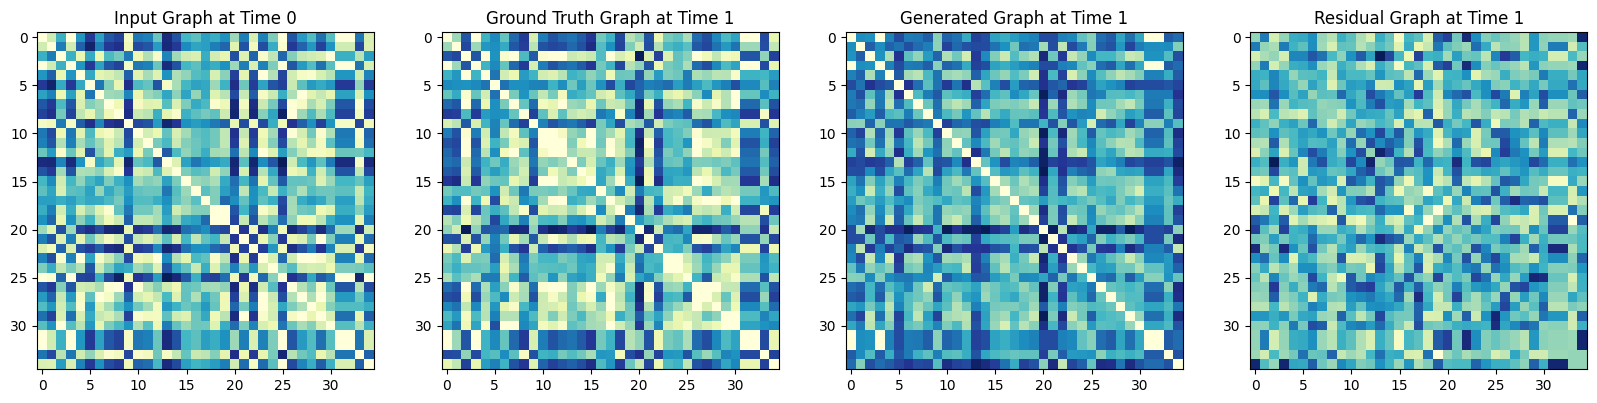

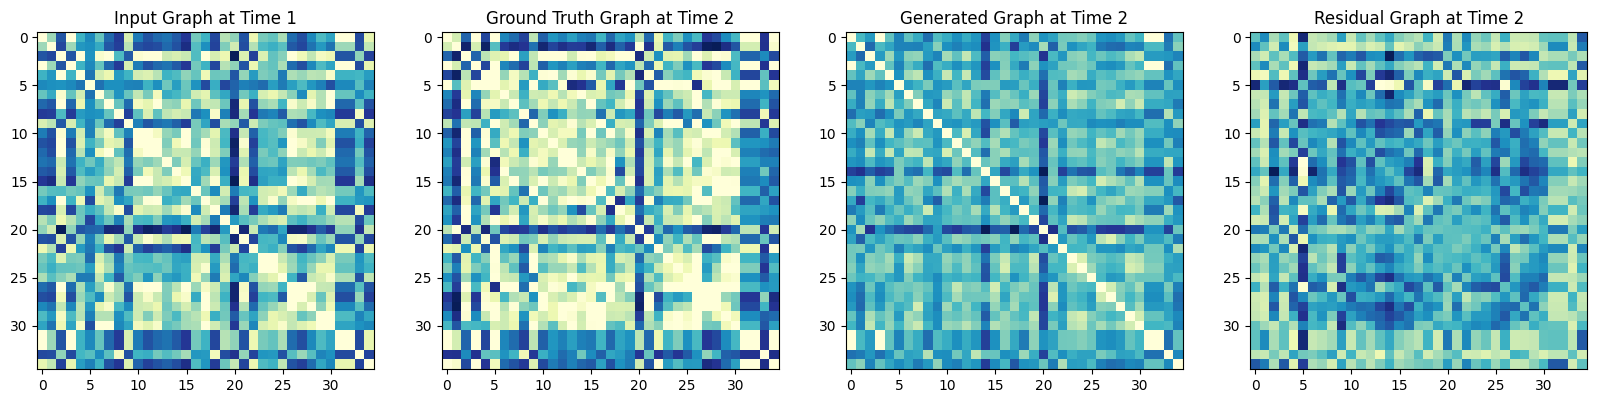

Mean Squared Error between ground truth graphs:  0.0002503937


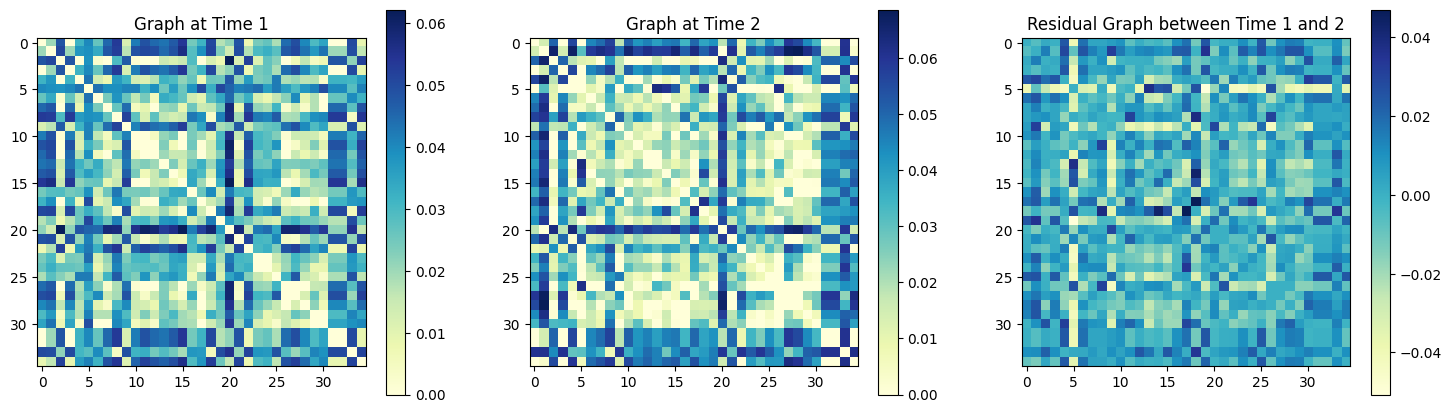

Mean Squared Error between generated graphs:  0.00010951343


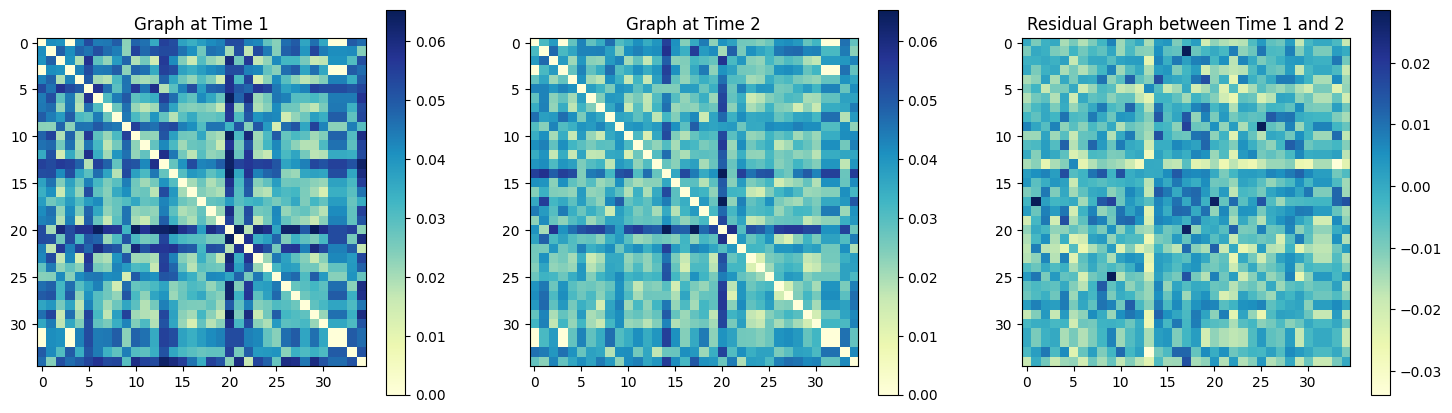

In [80]:
conv_size = adj_train_domain_1.shape[2]
hidden_size = conv_size*conv_size
model_1 = RBGM(conv_size, hidden_size).to(device)
model_2 = RBGM(conv_size, hidden_size).to(device)
rbgm_simulated_dom1_path = 'models/RBGM/rbgm_simulated_dom1'

# evaluation
set_seed(42)
model_1.eval()
model_2.eval()
mae_1, pcc_1, js_dis_1, avg_mae_bc_1, avg_mae_ec_1, avg_mae_pc_1 = evaluate_model(model_1, model_2, adj_test_domain_1.to(device))

# inference
inference_model(model_1, model_2, rbgm_simulated_dom1_path, adj_test_domain_1.to(device), sample_idx)